In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import random

In [2]:
compile_cmd = "make all"
subprocess.run(compile_cmd, shell=True, check=True)

g++ -std=c++17 -O2 -Wall fhn.cpp -o fhn
g++ -std=c++17 -O2 -Wall linard.cpp -o linard


CompletedProcess(args='make all', returncode=0)

In [3]:
np.random.seed(42)
stabilizing_time = 20000
window_size = 1

## Helper Functions
---

In [4]:
def AppendLocalOptima(csv_path, stabilizing_time, window_size, col_string):
    df = pd.read_csv(csv_path)
    df = df.iloc[stabilizing_time:]

    # the first window size values will also be nan because of how pandas rolling max works

    rolling_max = df[col_string].rolling(2 * window_size+ 1, center=True).max()
    rolling_min = df[col_string].rolling(2 * window_size+ 1, center=True).min()

    df['is_local_opt'] = (df[col_string] == rolling_max) | (df[col_string] == rolling_min)
    return df



In [5]:

def PlotExtrema(df, a, col_string): 
    plt.figure(figsize=(12, 6))

    mean_u = df[col_string].mean()
    std_u = df[col_string].std()

    plt.subplot(2, 1, 1)
    plt.plot(df['time'], df[col_string], label=col_string+'(t)')
    plt.title(f'u trajectory over time, A = {a}')
    plt.xlabel('Time')
    plt.ylabel(col_string)

    # Plot local optima
    plt.scatter(
        df.loc[df['is_local_opt'], 'time'],
        df.loc[df['is_local_opt'], col_string],
        color='red', marker='o', label='Local Optima', zorder=3
    )

    # Plot mean and ±6 std lines
    plt.axhline(mean_u, color='green', linestyle='--', label='Mean')
    plt.axhline(mean_u + 6 * std_u, color='orange', linestyle='--', label='Mean ± 6σ')
    plt.axhline(mean_u - 6 * std_u, color='orange', linestyle='--')

    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df['time'], df['v'])
    plt.title(f'v trajectory over time, A = {a}')
    plt.xlabel('Time')
    plt.ylabel('v')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/extrema_{a}.png')
    return


In [6]:

def process_timeseries(A, timeseries_dataframes, col_string, mode='all', n=None, subset=None):
    """
    Parameters:
    - A: list of identifiers (same length as timeseries_dataframes)
    - timeseries_dataframes: list of DataFrames corresponding to A
    - mode: 'all', 'random', or 'subset'
    - n: number of samples to select (used if mode == 'random')
    - subset: list of values to use from A (used if mode == 'subset')
    """

    # Convert to list of tuples for easier handling
    data_pairs = list(zip(A, timeseries_dataframes))

    if mode == 'all':
        selected = data_pairs

    elif mode == 'random':
        if n is None:
            raise ValueError("You must specify 'n' when using mode='random'")
        if n > len(A):
            raise ValueError(f"n={n} is greater than number of available elements={len(A)}")
        selected = random.sample(data_pairs, n)

    elif mode == 'subset':
        if subset is None:
            raise ValueError("You must provide a subset list when using mode='subset'")
        # Keep only those entries where a ∈ subset
        selected = [pair for pair in data_pairs if pair[0] in subset]

    else:
        raise ValueError("mode must be one of: 'all', 'random', or 'subset'")

    for a, df in selected:
        PlotExtrema(df, a, col_string)



In [7]:

def bifurcationdiagram(A, timeseries_dataframes):
    all_peak_data = []

    for a, df in zip(A, timeseries_dataframes):
        # Extract local optima for this 'a'
        peak_values = df["u"][df["is_local_opt"]]
        for val in peak_values:
            all_peak_data.append({'A': a, 'u_peak': val})

    # Convert to DataFrame
    peak_df = pd.DataFrame(all_peak_data)

    # Plot
    plt.figure(figsize=(8, 6))
    for a in sorted(peak_df['A'].unique()):
        peaks = peak_df[peak_df['A'] == a]['u_peak']
        x_vals = [a] * len(peaks)
        plt.scatter(x_vals, peaks, label=f"A = {a}", alpha=0.2)

    plt.xlabel("A value")
    plt.ylabel("Local optima of u")
    plt.title("Local Optima for Different Values of A")
    plt.grid(True)
    plt.show()

    return 

# FHN Model
---

In [8]:
u = np.random.random(size=10)*0.001 + -0.2
v = np.random.random(size = 10)*0.0001 + -0.002

In [9]:
A = np.linspace(0.62, 0.63, 101)

csv_paths_fhn = [(f"data/fhn/output_{a}_{u0}_{v0}.csv") for a in A for u0,v0 in zip(u, v)]

for u0, v0 in zip(u, v):
    for a in A:
        subprocess.run(f"./fhn {a} {u0} {v0}", shell=True, check=True)

In [ ]:
fhn_dataframes = [AppendLocalOptima(csv_path, stabilizing_time, window_size, col_string='u') for csv_path in csv_paths_fhn]
fhn_dataframes.head()

process_timeseries(A, fhn_dataframes, mode='subset', subset=[0.6239, 0.6256, 0.6268])


In [ ]:
bifurcationdiagram(A, fhn_dataframes)

# Linard Model
---

In [10]:
x = np.random.random(size=10) - 0.5
y = np.random.random(size = 10)
print(x)
print(y)

[ 0.11185289 -0.36050614 -0.20785535 -0.13363816 -0.04393002  0.28517596
 -0.30032622  0.01423444  0.09241457 -0.45354959]
[0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249]


In [11]:

omega_vals = np.linspace(0.64, 0.74, 101)
csv_paths_linard = [(f"data/linard/output_{omega}_{x0}_{y0}.csv") for x0, y0 in zip(x, y) for omega in omega_vals]

for x0, y0 in zip(x, y):
    for omega in omega_vals:
        subprocess.run(f"./linard {omega} {x0} {y0}", shell=True, check=True)

KeyError: 'v'

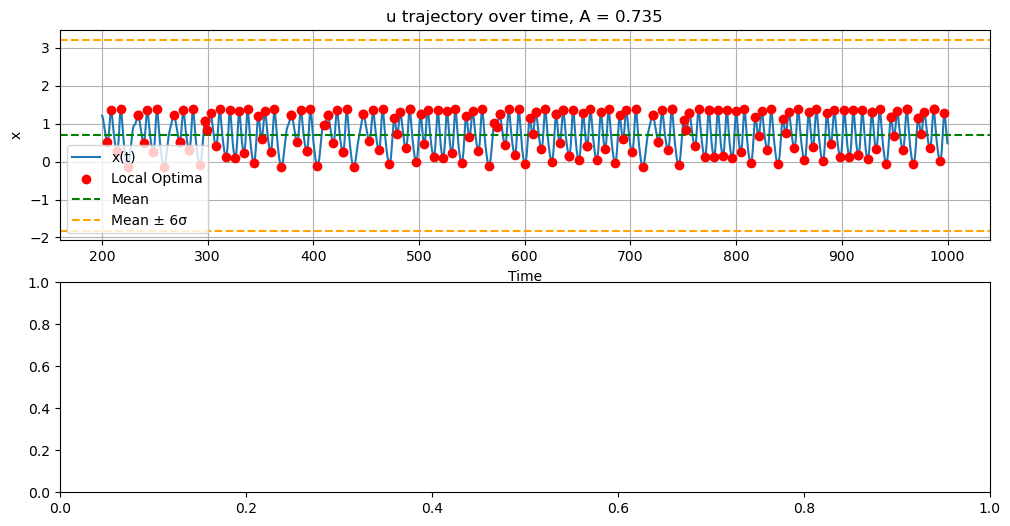

In [31]:
linard_dataframes = [AppendLocalOptima(csv_path, stabilizing_time, window_size, 'x') for csv_path in csv_paths_linard]
# linard_dataframes.head()

process_timeseries(omega_vals, linard_dataframes, 'x', mode='subset', subset=[0.735])

In [ ]:
bifurcationdiagram(omega_vals, linard_dataframes)

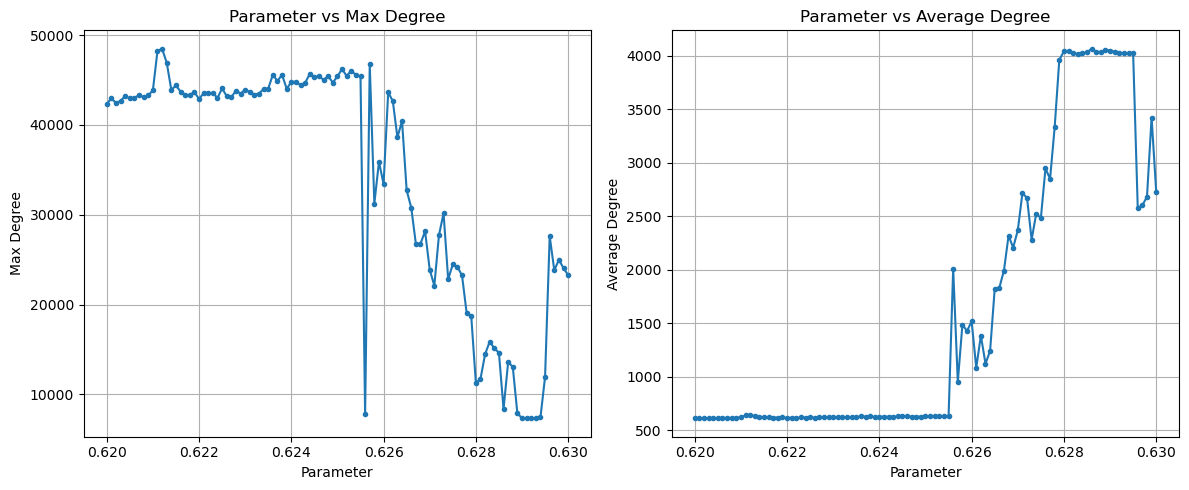

In [ ]:
def plotGraphMetrics():
    command = "./graph_metrics data/linard"
    
    graph_metrics = pd.read_csv('graph_metrics.csv')
# Sort by parameter column
graph_metrics = graph_metrics.sort_values('parameter')

# Convert parameter column to numeric for proper plotting
graph_metrics['parameter'] = pd.to_numeric(graph_metrics['parameter'])

# Create line plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(graph_metrics['parameter'], graph_metrics['max_degree'], marker='o', markersize=3)
plt.xlabel('Parameter')
plt.ylabel('Max Degree')
plt.title('Parameter vs Max Degree')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(graph_metrics['parameter'], graph_metrics['avg_degree'], marker='o', markersize=3)
plt.xlabel('Parameter')
plt.ylabel('Average Degree')
plt.title('Parameter vs Average Degree')
plt.grid(True)

plt.tight_layout()
plt.show()

# Linard Model
---

In [ ]:
A = np.linspace(0.62, 0.63, 101)
csv_paths = [(f"data/linard/output_{a}.csv") for a in A]

In [ ]:

compile_cmd = "g++ sim.cpp"
subprocess.run(compile_cmd, shell=True, check=True)
subprocess.run("mkdir -p data", shell=True, check=True)
subprocess.run("mkdir -p plots", shell=True, check=True)

for a in A:
    subprocess.run(f"./a.out {a}", shell=True, check=True)

In [ ]:

def AppendLocalOptima(csv_path, stabilizing_time, window_size):
    df = pd.read_csv(csv_path)
    df = df.iloc[stabilizing_time:]

    # the first window size values will also be nan because of how pandas rolling max works

    rolling_max = df['u'].rolling(2 * window_size+ 1, center=True).max()
    rolling_min = df['u'].rolling(2 * window_size+ 1, center=True).min()

    df['is_local_opt'] = (df['u'] == rolling_max) | (df['u'] == rolling_min)
    return df

stabilizing_time = 20000
window_size = 1

timeseries_dataframes = [AppendLocalOptima(csv_path, stabilizing_time, window_size) for csv_path in csv_paths]
print(timeseries_dataframes[0])
